In [47]:
import pandas as pd
from datetime import datetime, timedelta
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [48]:
business = pd.read_csv('business.csv')
economy = pd.read_csv('economy.csv')

In [49]:
business['flight_class'] = 'business'
economy['flight_class'] = 'economy'

data = pd.concat([business, economy], ignore_index=True)

data.drop_duplicates(inplace=True)

data.dropna(inplace=True)

In [50]:
data.rename(columns={
    'date': 'flight_date',
    'airline': 'airline_name',
    'ch_code': 'carrier_code',
    'num_code': 'flight_number',
    'dep_time': 'departure_time',
    'from': 'departure_city',
    'time_taken': 'flight_duration',
    'stop': 'number_of_stops',
    'arr_time': 'arrival_time',
    'to': 'arrival_city',
    'price': 'ticket_price'
}, inplace=True)

data['flight_id'] = data['carrier_code'] + data['flight_number'].astype(str)

data.drop(columns=['carrier_code', 'flight_number'], inplace=True)

data['ticket_price'] = data['ticket_price'].str.replace(',', '').astype(int)

In [51]:
def calculate_duration(dep_time, arr_time):
    try:
        departure = datetime.strptime(dep_time, '%H:%M')
        arrival = datetime.strptime(arr_time, '%H:%M')
        if arrival < departure:  
            arrival += timedelta(days=1)
        duration_in_seconds = (arrival - departure).seconds
        return round(duration_in_seconds / 3600, 2)
    except ValueError:
        return None

data['flight_duration'] = data.apply(lambda x: calculate_duration(x['departure_time'], x['arrival_time']), axis=1)

In [52]:
def preprocess_stop_column(value):
    if isinstance(value, str):
        value = value.strip().lower()
        if 'non-stop' in value:
            return 0
        elif '2+-stop' in value:
            return 2
        else:
            return 1
    return value

data['number_of_stops'] = data['number_of_stops'].apply(preprocess_stop_column).astype(int)

In [53]:
def categorize_time(time_str):
    try:
        hour = int(time_str.split(':')[0])
        if 0 <= hour < 6:
            return "Early Morning"
        elif 6 <= hour < 12:
            return "Morning"
        elif 12 <= hour < 17:
            return "Afternoon"
        elif 17 <= hour < 21:
            return "Evening"
        else:
            return "Night"
    except ValueError:
        return "Unknown"

data['departure_time'] = data['departure_time'].apply(categorize_time)
data['arrival_time'] = data['arrival_time'].apply(categorize_time)

In [54]:
filtered_data = data[
    (data['departure_city'] == 'Delhi') & 
    (data['arrival_city'] == 'Mumbai') &
    (data['airline_name'] == 'Vistara') & 
    (data['flight_id'] == 'UK706') &
    (data['arrival_time'] == 'Night')
]

filtered_data['flight_date'] = pd.to_datetime(filtered_data['flight_date'], format='%d-%m-%Y')
filtered_data.sort_values('flight_date', inplace=True)
filtered_data.set_index('flight_date', inplace=True)
filtered_data = filtered_data.drop(columns='flight_id', axis=1)

filtered_data['day_of_week'] = filtered_data.index.dayofweek
filtered_data['is_weekend'] = (filtered_data['day_of_week'] >= 5).astype(int)

In [55]:
filtered_data

,airline_name,departure_time,departure_city,flight_duration,number_of_stops,arrival_time,arrival_city,ticket_price,flight_class,day_of_week,is_weekend
flight_date,,,,,,,,,,,
2022-02-12,Vistara,Afternoon,Delhi,7.92,1,Night,Mumbai,58524,business,5,1
2022-02-12,Vistara,Afternoon,Delhi,7.92,1,Night,Mumbai,15038,economy,5,1
2022-02-13,Vistara,Afternoon,Delhi,7.92,1,Night,Mumbai,19238,economy,6,1
2022-02-14,Vistara,Afternoon,Delhi,7.92,1,Night,Mumbai,10575,economy,0,0
2022-02-14,Vistara,Afternoon,Delhi,7.92,1,Night,Mumbai,42956,business,0,0
...,...,...,...,...,...,...,...,...,...,...,...
2022-03-29,Vistara,Afternoon,Delhi,7.92,1,Night,Mumbai,36577,business,1,0
2022-03-30,Vistara,Afternoon,Delhi,7.92,1,Night,Mumbai,36577,business,2,0
2022-03-30,Vistara,Afternoon,Delhi,7.92,1,Night,Mumbai,4673,economy,2,0


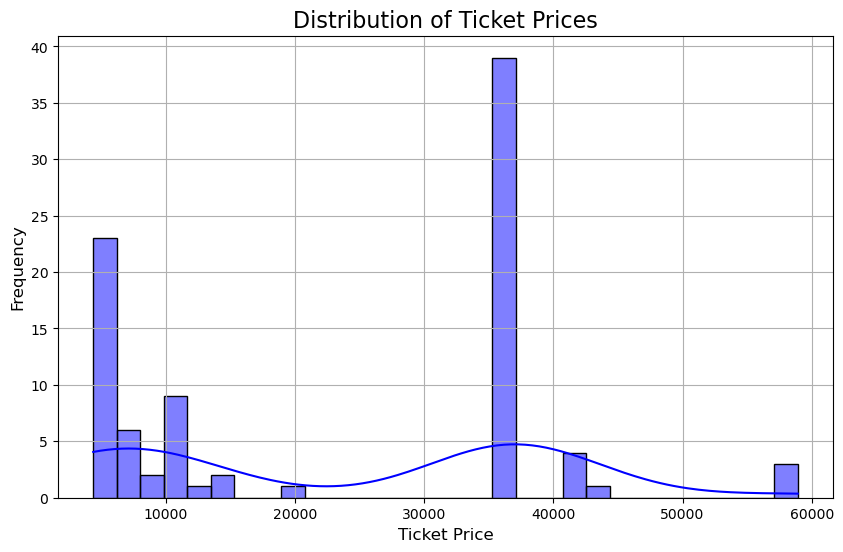

In [56]:
plt.figure(figsize=(10, 6))
sns.histplot(filtered_data['ticket_price'], kde=True, bins=30, color='blue')
plt.title('Distribution of Ticket Prices', fontsize=16)
plt.xlabel('Ticket Price', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.grid()
plt.show()

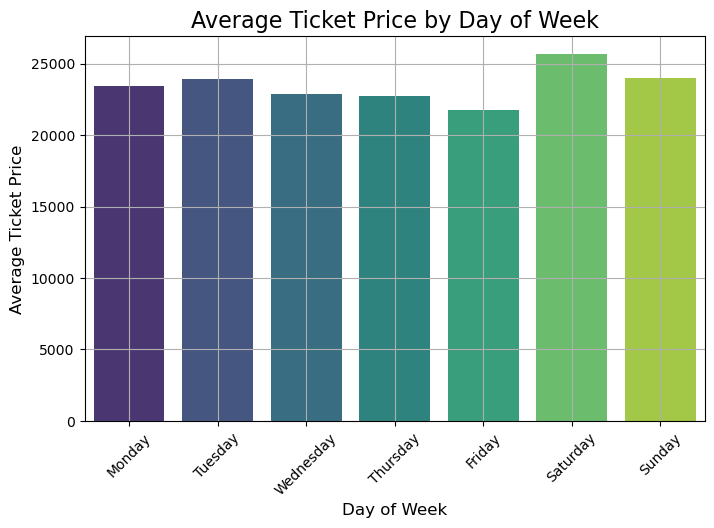

In [57]:
plt.figure(figsize=(8, 5))
day_labels = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
avg_price_by_day = filtered_data.groupby('day_of_week')['ticket_price'].mean()
sns.barplot(x=avg_price_by_day.index, y=avg_price_by_day.values, palette='viridis')
plt.title('Average Ticket Price by Day of Week', fontsize=16)
plt.xlabel('Day of Week', fontsize=12)
plt.ylabel('Average Ticket Price', fontsize=12)
plt.xticks(ticks=range(7), labels=day_labels, rotation=45)
plt.grid()
plt.show()

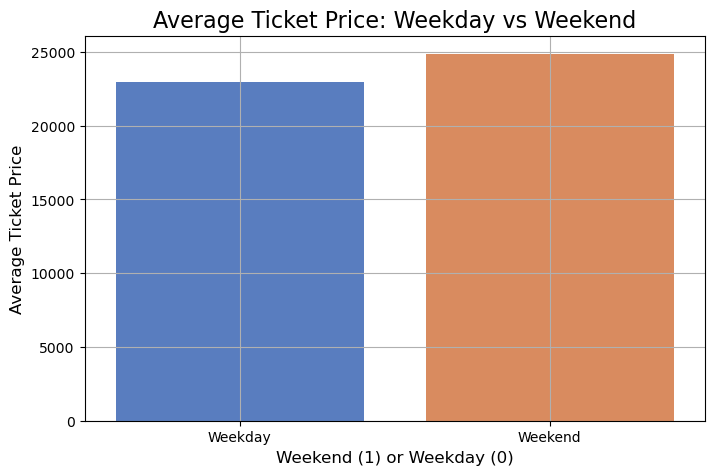

In [58]:
plt.figure(figsize=(8, 5))
avg_price_weekend = filtered_data.groupby('is_weekend')['ticket_price'].mean()
sns.barplot(x=avg_price_weekend.index, y=avg_price_weekend.values, palette='muted')
plt.title('Average Ticket Price: Weekday vs Weekend', fontsize=16)
plt.xlabel('Weekend (1) or Weekday (0)', fontsize=12)
plt.ylabel('Average Ticket Price', fontsize=12)
plt.xticks([0, 1], labels=['Weekday', 'Weekend'])
plt.grid()
plt.show()

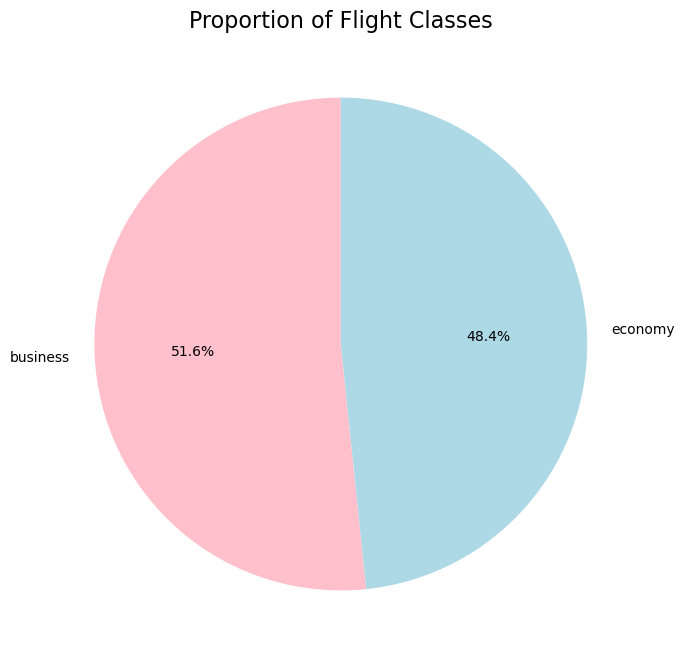

In [59]:
plt.figure(figsize=(8, 8))
flight_class_counts = filtered_data['flight_class'].value_counts()
plt.pie(flight_class_counts, labels=flight_class_counts.index, autopct='%1.1f%%', startangle=90, colors=['pink', 'lightblue'])
plt.title('Proportion of Flight Classes', fontsize=16)
plt.show()

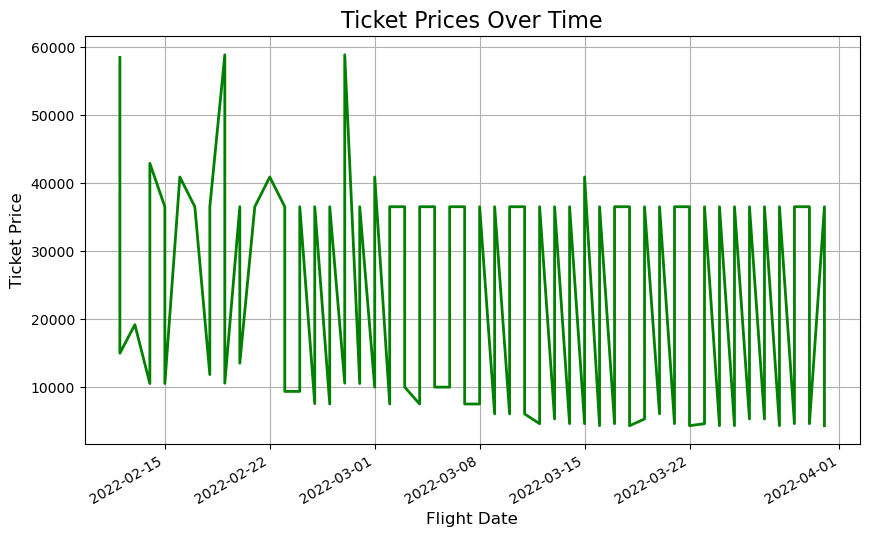

In [60]:
plt.figure(figsize=(10, 6))
filtered_data['ticket_price'].plot(linewidth=2, color='green')
plt.title('Ticket Prices Over Time', fontsize=16)
plt.xlabel('Flight Date', fontsize=12)
plt.ylabel('Ticket Price', fontsize=12)
plt.grid()
plt.show()